#### Import Required Packages

In [271]:
import gurobipy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import csv
import os
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

#### Read data and transform for use

In [272]:

# 2019 Data
stocks2019 = pd.read_csv('stocks2019.csv') 
stocks2019.iloc[:, 0] = pd.to_datetime(stocks2019.iloc[:, 0]) #convert the first column to datetime
stocks2019.set_index(stocks2019.columns[0], inplace=True) #set the first column as index
stocks2019.index = stocks2019.index.rename('Date') #rename the index to 'Date'

# 2020 Data
stocks2020 = pd.read_csv('stocks2020.csv') 
stocks2020.iloc[:, 0] = pd.to_datetime(stocks2020.iloc[:, 0]) #convert the first column to datetime
stocks2020.set_index(stocks2020.columns[0], inplace=True) #set the first column as index
stocks2020.index = stocks2020.index.rename('Date') #rename the index to 'Date'


#### Part 1. Calculate Returns and Correlations

In [273]:
#Calculate index and stock returns
index_returns_2019 = stocks2019.iloc[:,0].pct_change()[1:]
stock_returns_2019 = stocks2019.iloc[:,1:].pct_change()[1:]

index_returns_2020 = stocks2020.iloc[:,0].pct_change()[1:]
stock_returns_2020 = stocks2020.iloc[:,1:].pct_change()[1:]

#Calculate stock correlation for 2019 returns
corr_2019 = stock_returns_2019.corr()

#Create dataframe for storing fund returns later on
fund_returns = pd.DataFrame() # DataFrame to different fund returns
fund_returns['Date'] = index_returns_2019.index
fund_returns.set_index('Date', inplace=True)

fund_returns_2020 = pd.DataFrame() # DataFrame to different fund returns
fund_returns_2020['Date'] = index_returns_2020.index
fund_returns_2020.set_index('Date', inplace=True)

fund_returns_MIP = pd.DataFrame() # DataFrame to different fund returns
fund_returns_MIP['Date'] = index_returns_2019.index
fund_returns_MIP.set_index('Date', inplace=True)

fund_returns_MIP_2020 = pd.DataFrame() # DataFrame to different fund returns
fund_returns_MIP_2020['Date'] = index_returns_2020.index
fund_returns_MIP_2020.set_index('Date', inplace=True)

##### 2019 Stock Returns

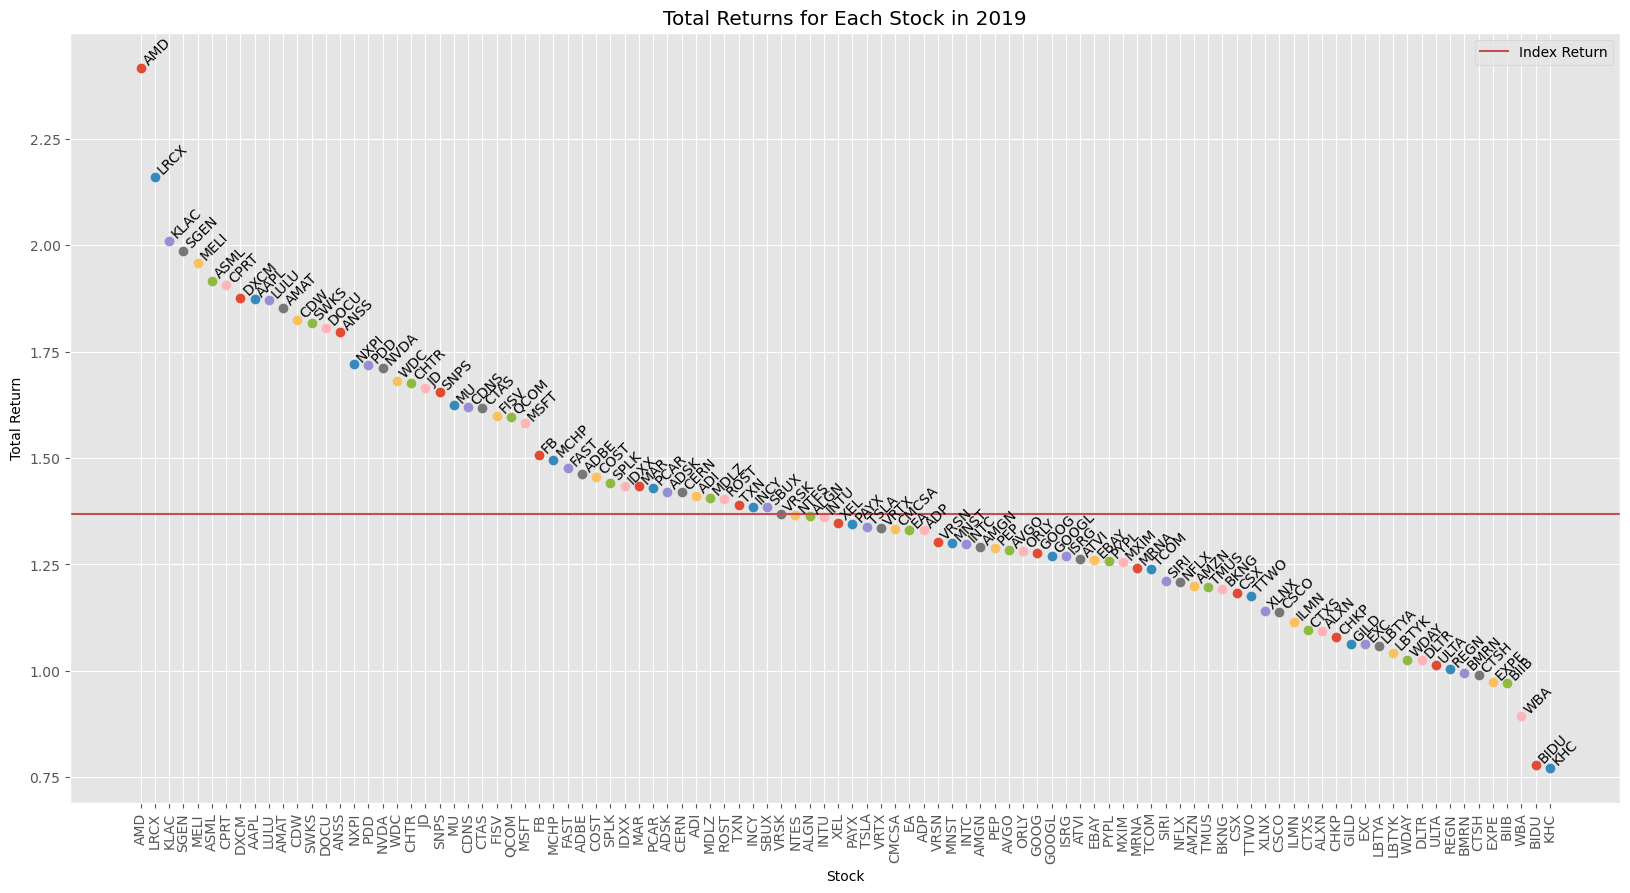

In [274]:
# Calculate cumulative product of returns for stocks
total_returns = (stock_returns_2019 + 1).prod()

# Calculate cumulative product of returns for the index
total_index_return = (index_returns_2019 + 1).prod()

# Sort the series by return level
total_returns_sorted = total_returns.sort_values(ascending=False)

# Create a new figure with specified size
plt.figure(figsize=(20, 10))

# Plot each point with a 'o' marker for stocks
for stock, return_ in total_returns_sorted.items():
    plt.plot(stock, return_, marker='o', linestyle='')

    # Add a label for each point with a 45-degree rotation
    plt.text(stock, return_, stock, ha='left', va='bottom', rotation=45)

# Plot a horizontal line representing the index return
plt.axhline(y=total_index_return, color='r', linestyle='-', label='Index Return')

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Stock')
plt.ylabel('Total Return')
plt.title('Total Returns for Each Stock in 2019')

# Add a legend
plt.legend()

# Show plot
plt.show()


##### 2020 Stock Returns

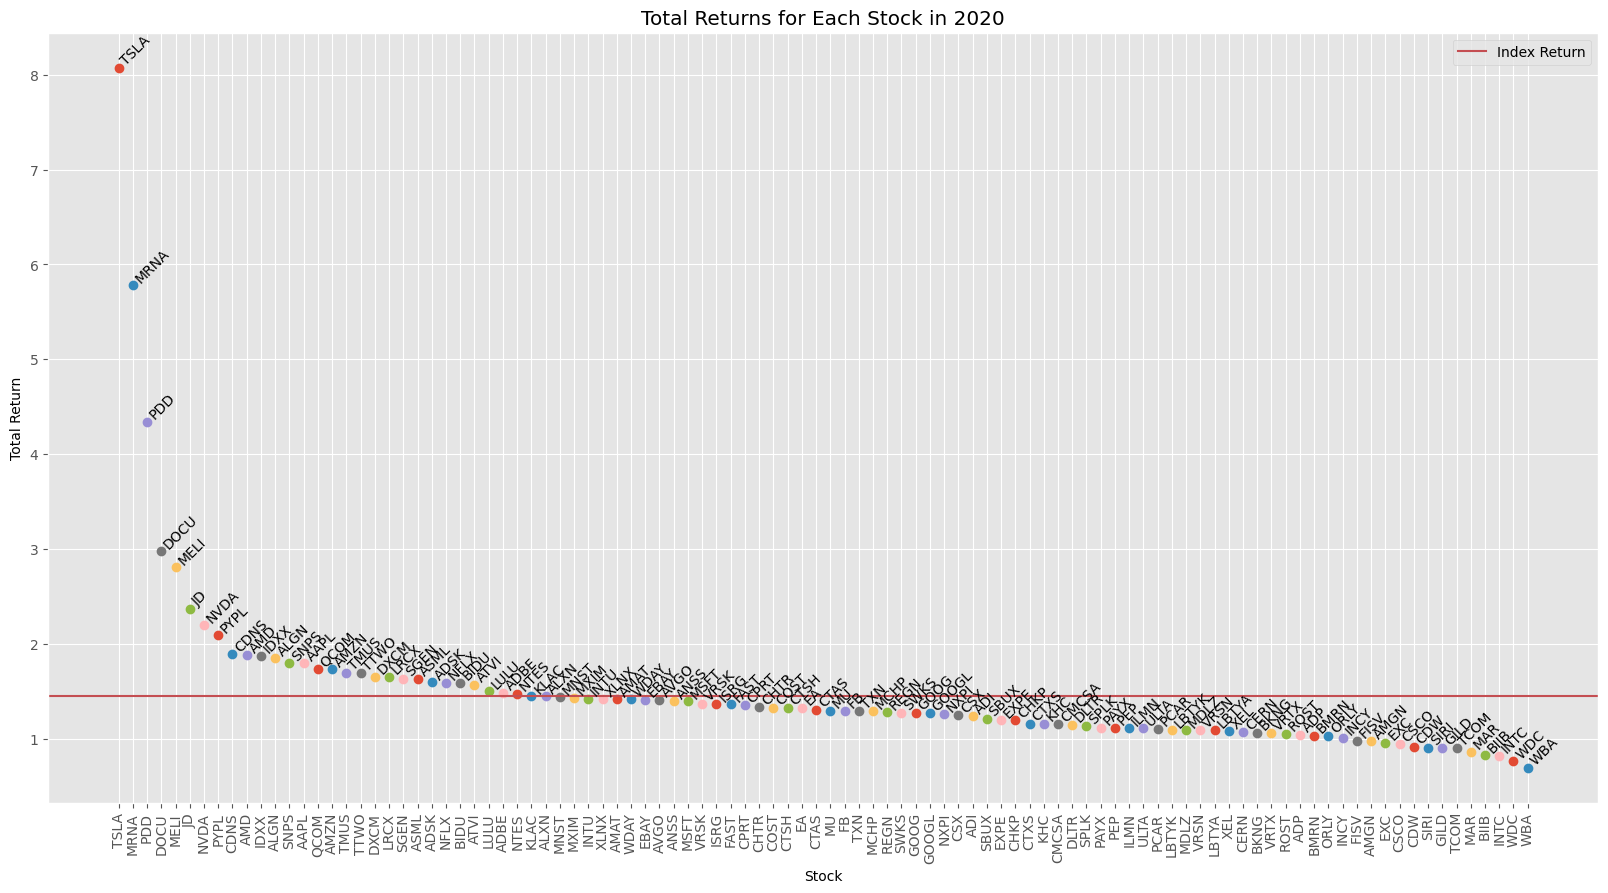

In [275]:
# Calculate cumulative product of returns for stocks
total_returns = (stock_returns_2020 + 1).prod()

# Calculate cumulative product of returns for the index
total_index_return = (index_returns_2020 + 1).prod()

# Sort the series by return level
total_returns_sorted = total_returns.sort_values(ascending=False)

# Create a new figure with specified size
plt.figure(figsize=(20, 10))

# Plot each point with a 'o' marker for stocks
for stock, return_ in total_returns_sorted.items():
    plt.plot(stock, return_, marker='o', linestyle='')

    # Add a label for each point with a 45-degree rotation
    plt.text(stock, return_, stock, ha='left', va='bottom', rotation=45)

# Plot a horizontal line representing the index return
plt.axhline(y=total_index_return, color='r', linestyle='-', label='Index Return')

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Stock')
plt.ylabel('Total Return')
plt.title('Total Returns for Each Stock in 2020')

# Add a legend
plt.legend()

# Show plot
plt.show()


#### Question 2. Construct portfolio using only 5 stocks

In [276]:
n_index = len(corr_2019)  # number of stocks in index

m = 5 # number of stocks in fund

# Model to find best m representative stocks
model = gp.Model()

x = model.addMVar(shape=(n_index, n_index), vtype='B')
y = model.addMVar(shape=n_index, vtype='B')

# Constraints
model.addConstr(gp.quicksum(y[j] for j in range(n_index)) == m)  # m stocks allowed in fund
model.addConstrs((gp.quicksum(x[i, j] for j in range(n_index)) == 1 for i in range(n_index))) # only 1 representative for each stock
model.addConstrs((x[i, j] <= y[j] for i in range(n_index) for j in range(n_index))) # stocks not picked cannot be representative

# Objective
model.setObjective(gp.quicksum(gp.quicksum(corr_2019.iloc[i, j] * x[i, j] for j in range(n_index)) for i in range(n_index)), sense=gp.GRB.MAXIMIZE)

# Solve model
model.Params.outputflag = 0
model.optimize()

# Portfolio
portfolio_indices = [i for i, x in enumerate(y.x) if x == 1]
portfolio_returns = stock_returns_2019.iloc[:,portfolio_indices]
portfolio_returns_2020 = stock_returns_2020.iloc[:,portfolio_indices]

# Model to find weights for portfolio stocks
T = len(stock_returns_2019) # no of trading days

model = gp.Model()
w = model.addMVar(m, ub = 1, lb = 0) #weights
r = model.addMVar(T) #residue

# Constraints
model.addConstr( gp.quicksum(w[i] for i in range(m)) == 1 ) # weights add up to 1
model.addConstrs(  index_returns_2019.iloc[t] - gp.quicksum( w[i] * portfolio_returns.iloc[t, i ] for i in range(m)) <= r[t] for t in range(T)) # minimize difference if positive 
model.addConstrs( -index_returns_2019.iloc[t] + gp.quicksum( w[i] * portfolio_returns.iloc[t, i ] for i in range(m)) <= r[t] for t in range(T)) # minimize difference if negative 

#Objective and solution
model.setObjective(gp.quicksum(r[t] for t in range(T)))
model.Params.outputflag = 0
model.Params.warningflag = 0
model.optimize()

# Calculate and store daily portfolio returns in dataframe

fund_returns_5 = (portfolio_returns[:]*w.x).sum(axis = 1)
fund_returns_5_2020 = (portfolio_returns_2020[:]*w.x).sum(axis = 1)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


#### Selected stocks and their weights

Selected stocks and their weights:
LBTYK : 0.04886174835252491
MXIM : 0.21038806005665553
MSFT : 0.5803519807862964
VRTX : 0.07119021516911038
XEL : 0.08920799563541282


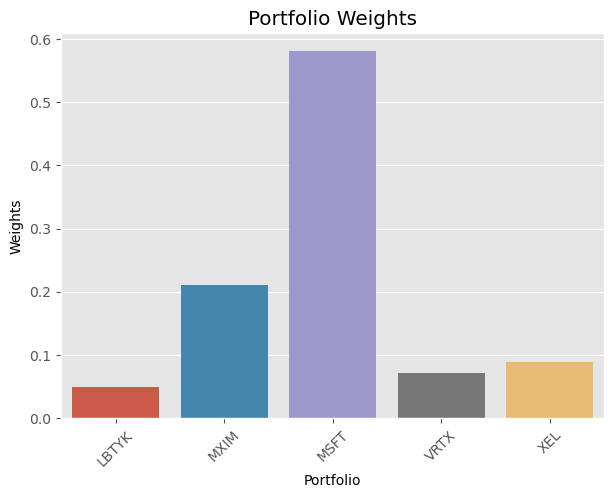

In [277]:

labels = portfolio_returns.columns
values = [w.x[i] for i in range(m)]  # replace 'm' with the actual range

print('Selected stocks and their weights:')
for i in range(m):
    print(labels[i], ':', w.x[i])

plt.figure(figsize=(7, 5))

# Create barplot
sns.barplot(x=labels, y=values)

# Adding title and labels
plt.title('Portfolio Weights')
plt.xlabel('Portfolio')
plt.ylabel('Weights')

# Rotate x labels if they are long
plt.xticks(rotation=45)

plt.show()


Fund Return EOY: 0.39936180034243685
Index Return EOY: 0.3692671456570791
Difference in return: 0.03009465468535777


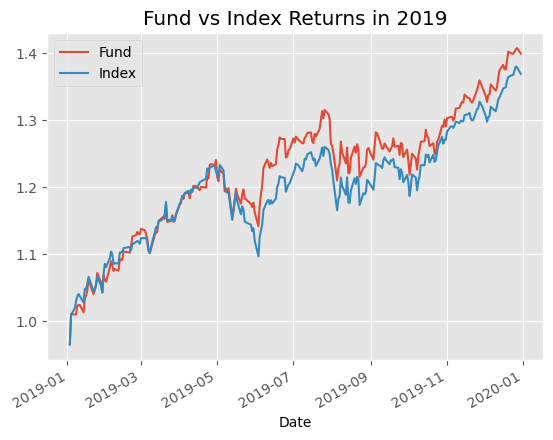

In [261]:
print('Fund Return EOY:', fund_returns_5.add(1).prod() - 1)
print('Index Return EOY:', index_returns_2019.add(1).prod() - 1)
print('Difference in return:', fund_returns_5.add(1).prod() - 1 - (index_returns_2019.add(1).prod() - 1))

fund_returns_5.add(1).cumprod().plot()
index_returns_2019.add(1).cumprod().plot()
plt.legend(['Fund', 'Index'])
plt.title('Fund vs Index Returns in 2019')
plt.show()


#### Comparing Fund out of sample (2020 data)

Fund Return EOY: 0.3566923265008968
Index Return EOY: 0.44781810474202954
Difference in return: -0.09112577824113277


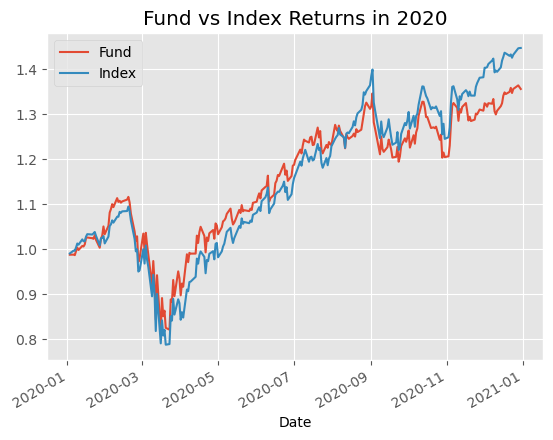

In [278]:
print('Fund Return EOY:', fund_returns_5_2020.add(1).prod() - 1)
print('Index Return EOY:', index_returns_2020.add(1).prod() - 1)
print('Difference in return:', fund_returns_5_2020.add(1).prod() - 1 - (index_returns_2020.add(1).prod() - 1))

fund_returns_5_2020.add(1).cumprod().plot()
index_returns_2020.add(1).cumprod().plot()
plt.legend(['Fund', 'Index'])
plt.title('Fund vs Index Returns in 2020')
plt.show()


#### Daily deviations

Average of absolute daily deviations: 0.00315671312985259


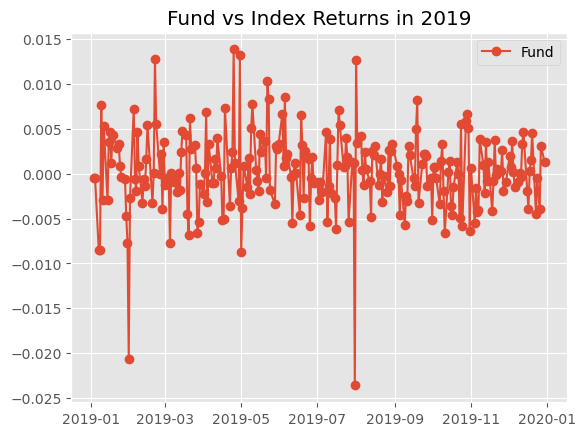

In [279]:
print('Average of absolute daily deviations:', fund_returns_5.sub(index_returns_2019).abs().mean())

plt.plot(fund_returns_5 - index_returns_2019, '-o')
plt.legend(['Fund', 'Index'])
plt.title('Fund vs Index Returns in 2019')
plt.show()


#### Question 3. Run the model for different values of m

In [280]:
n_index = len(corr_2019)  # number of stocks in index

returns = pd.DataFrame() # DataFrame to different fund returns
returns['Date'] = index_returns_2019.index
returns.set_index('Date', inplace=True)

returns_2020 = pd.DataFrame() # DataFrame to different fund returns
returns_2020['Date'] = index_returns_2020.index
returns_2020.set_index('Date', inplace=True)

# df for capturing m, stock and its weight
weights_IP  = pd.DataFrame(columns=['m', 'Stock', 'Weight'])

# Iterate over different portfolio sizes
for m in range(10, min(n_index + 1, ((n_index // 10) + 1) * 10), 10):

    # Model to find best m representative stocks
    model = gp.Model()

    x = model.addMVar(shape=(n_index, n_index), vtype='B')
    y = model.addMVar(shape=n_index, vtype='B')

    # Constraints
    model.addConstr(gp.quicksum(y[j] for j in range(n_index)) == m)  # m stocks allowed in fund
    model.addConstrs((gp.quicksum(x[i, j] for j in range(n_index)) == 1 for i in range(n_index))) # only 1 representative for each stock
    model.addConstrs((x[i, j] <= y[j] for i in range(n_index) for j in range(n_index))) # stocks not picked cannot be representative

    # Objective
    model.setObjective(gp.quicksum(gp.quicksum(corr_2019.iloc[i, j] * x[i, j] for j in range(n_index)) for i in range(n_index)), sense=gp.GRB.MAXIMIZE)

    # Solve model
    model.Params.outputflag = 0
    model.optimize()

    # Portfolio
    portfolio_indices = [i for i, x in enumerate(y.x) if x == 1]
    portfolio_returns = stock_returns_2019.iloc[:,portfolio_indices]
    portfolio_returns_2020 = stock_returns_2020.iloc[:,portfolio_indices]

    # Model to find weights for portfolio stocks
    T = len(stock_returns_2019) # no of trading days

    model = gp.Model()
    w = model.addMVar(m, ub = 1, lb = 0) #weights
    r = model.addMVar(T) #residue
    
    # Constraints
    model.addConstr( gp.quicksum(w[i] for i in range(m)) == 1 ) # weights add up to 1
    model.addConstrs(  index_returns_2019.iloc[t] - gp.quicksum( w[i] * portfolio_returns.iloc[t, i ] for i in range(m)) <= r[t] for t in range(T)) # minimize difference if positive 
    model.addConstrs( -index_returns_2019.iloc[t] + gp.quicksum( w[i] * portfolio_returns.iloc[t, i ] for i in range(m)) <= r[t] for t in range(T)) # minimize difference if negative 

    #Objective and solution
    model.setObjective(gp.quicksum(r[t] for t in range(T)))
    model.Params.outputflag = 0
    model.Params.warningflag = 0
    model.optimize()

    # Calculate and store daily portfolio returns in dataframe

    returns[f'fund_returns_{m}'] = (portfolio_returns[:]*w.x).sum(axis = 1)
    returns_2020[f'fund_returns_{m}'] = (portfolio_returns_2020[:]*w.x).sum(axis = 1)
    weights_IP = pd.concat([weights_IP, pd.DataFrame({'m': m, 'Stock': portfolio_returns.columns, 'Weight': w.x})], ignore_index=True)


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


#### Difference of 2019 EOY returns for each fund from index returns

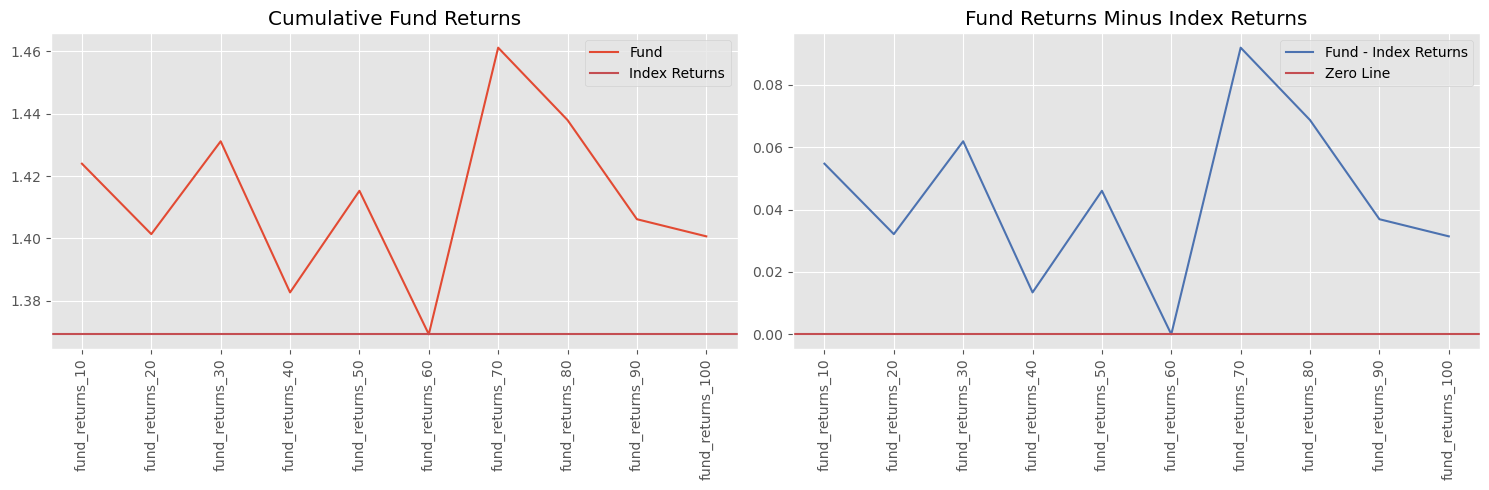

In [281]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (stacked vertically)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize to better fit both plots

# Calculate cumulative fund returns and index returns
cumulative_fund_returns = returns.add(1).prod()
index_returns = index_returns_2019.add(1).prod()

# First subplot with cumulative fund returns
axes[0].plot(cumulative_fund_returns, label='Fund')
axes[0].axhline(y=index_returns, color='r', linestyle='-', label='Index Returns')
for label in axes[0].get_xticklabels():
    label.set_rotation(90)
axes[0].legend()  # Show the legend
axes[0].set_title('Cumulative Fund Returns')

# Second subplot with the difference from the index
returns_difference = cumulative_fund_returns - index_returns
axes[1].plot(returns_difference, label='Fund - Index Returns', color='b')
axes[1].axhline(y=0, color='r', linestyle='-', label='Zero Line')
for label in axes[1].get_xticklabels():
    label.set_rotation(90)
axes[1].legend()  # Show the legend
axes[1].set_title('Fund Returns Minus Index Returns')

plt.tight_layout()  # Ensure a neat layout
plt.show()  # Display the plots


#

#### Difference of 2020 EOY returns for each fund from index returns

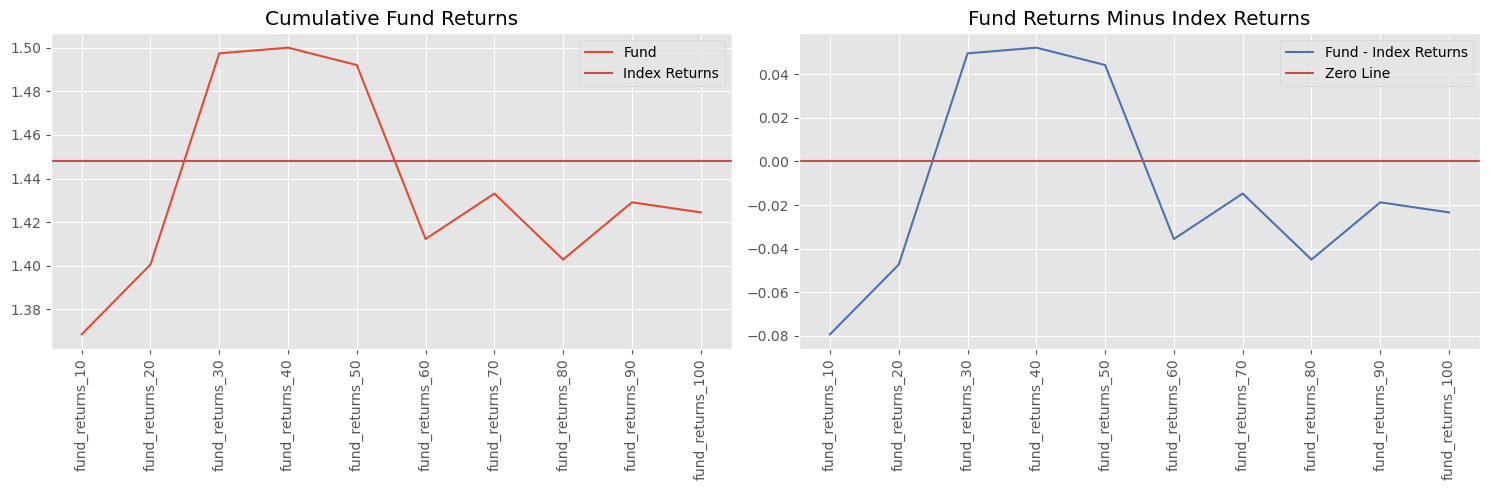

In [282]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (stacked vertically)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize to better fit both plots

# Calculate cumulative fund returns and index returns
cumulative_fund_returns = returns_2020.add(1).prod()
index_returns = index_returns_2020.add(1).prod()

# First subplot with cumulative fund returns
axes[0].plot(cumulative_fund_returns, label='Fund')
axes[0].axhline(y=index_returns, color='r', linestyle='-', label='Index Returns')
for label in axes[0].get_xticklabels():
    label.set_rotation(90)
axes[0].legend()  # Show the legend
axes[0].set_title('Cumulative Fund Returns')

# Second subplot with the difference from the index
returns_difference = cumulative_fund_returns - index_returns
axes[1].plot(returns_difference, label='Fund - Index Returns', color='b')
axes[1].axhline(y=0, color='r', linestyle='-', label='Zero Line')
for label in axes[1].get_xticklabels():
    label.set_rotation(90)
axes[1].legend()  # Show the legend
axes[1].set_title('Fund Returns Minus Index Returns')

plt.tight_layout()  # Ensure a neat layout
plt.show()  # Display the plots


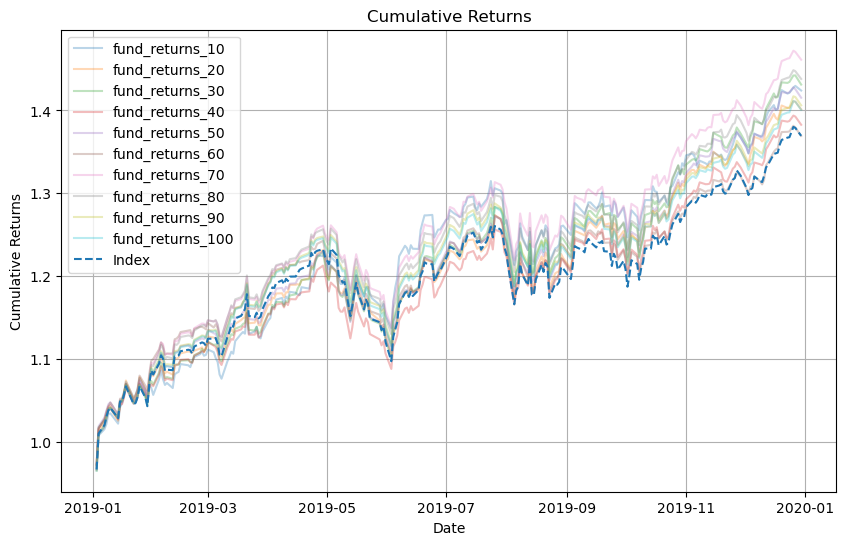

In [284]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(10, 6))

# Plot cumulative returns for all funds with 50% opacity
for column in returns.columns:
    plt.plot(returns.index, returns[column].add(1).cumprod(), label=column, alpha=0.3)

# Plot cumulative returns for the index with full opacity and a different line style
plt.plot(index_returns_2019.index, index_returns_2019.add(1).cumprod(), label='Index', linestyle='--', alpha=1.0)

# Add a legend, title, and axis labels, and enable the grid
plt.legend(loc='upper left')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)

# Show the plot
plt.show()


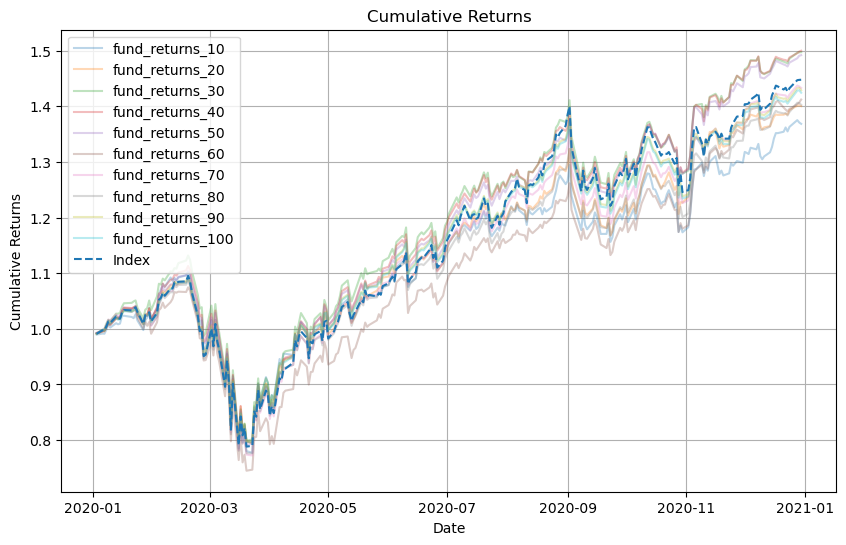

In [285]:
# Compare returns out of sample for 2020 data
plt.style.use('default')
plt.figure(figsize=(10, 6))

# Plot cumulative returns for all funds with 50% opacity
for column in returns_2020.columns:
    plt.plot(returns_2020.index, returns_2020[column].add(1).cumprod(), label=column, alpha=0.3)

# Plot cumulative returns for the index with full opacity and a different line style
plt.plot(index_returns_2020.index, index_returns_2020.add(1).cumprod(), label='Index', linestyle='--', alpha=1.0)

# Add a legend, title, and axis labels, and enable the grid
plt.legend(loc='upper left')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)

# Show the plot
plt.show()

    


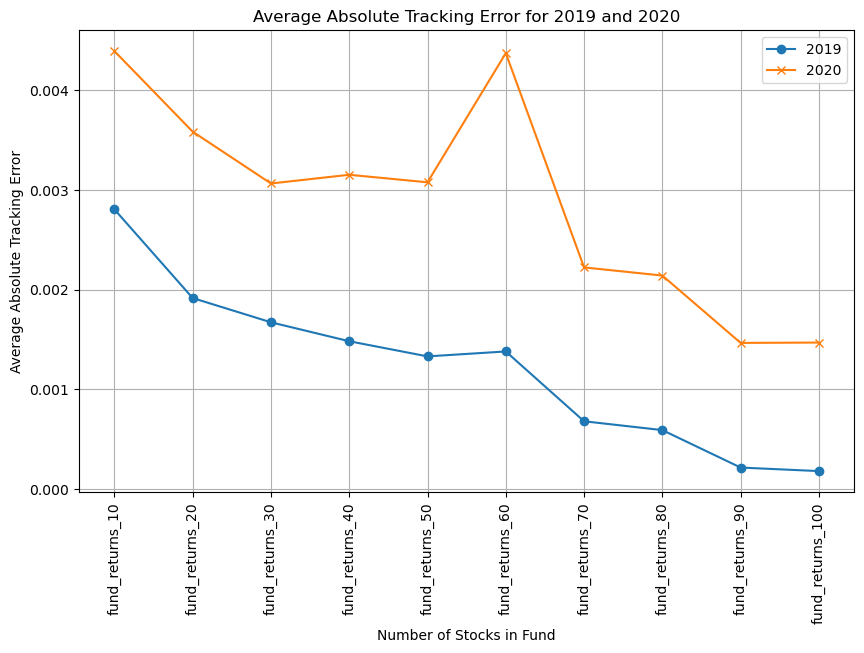

In [286]:
import matplotlib.pyplot as plt

# Calculate tracking errors
tracking_error = returns.subtract(index_returns_2019, axis=0)
tracking_error_2020 = returns_2020.subtract(index_returns_2020, axis=0)

# Create a single figure and axes for both plots
plt.figure(figsize=(10, 6))

# Plot the average absolute tracking error for each year
plt.plot(tracking_error.columns, tracking_error.abs().mean(), marker='o', label='2019')
plt.plot(tracking_error_2020.columns, tracking_error_2020.abs().mean(), marker='x', label='2020')

# Customize the plot
plt.xticks(rotation=90)
plt.title('Average Absolute Tracking Error for 2019 and 2020')
plt.xlabel('Number of Stocks in Fund')
plt.ylabel('Average Absolute Tracking Error')
plt.grid(True)
plt.legend()  # Show the legend to distinguish between years

# Show the combined plot
plt.show()


#### Question 4. Mixed Integer Programming

In [3]:
N = len(stock_returns_2019.columns)
T = len(stock_returns_2019)
M = 1  # one stock can take a max value of 100% of the portfolio
time_limit = 3600  # 1 hour

# Initialize a DataFrame to store returns
portfolio_returns_df = pd.DataFrame()

if not os.path.exists('optimization_proj_2.csv'):

    # CSV setup
    with open('optimization_proj_2.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        # Write the headers
        csvwriter.writerow(["m","Stock", "Weight"])

        for m in range(10, min(n_index + 1, ((n_index // 10) + 1) * 10), 10):

            model = gp.Model()

            # Variables
            y = model.addVars(N, vtype='B') # indicating if a stock has a non-zero weight
            w = model.addVars(N, vtype='C') # weights
            r = model.addVars(T, vtype='C') # residuals

            # Objective
            model.setObjective(gp.quicksum(r[t] for t in range(T)), sense=gp.GRB.MINIMIZE)

            # Constraints
            model.addConstrs(r[t] >= index_returns_2019[t] - gp.quicksum(w[i] * stock_returns_2019.iloc[t, i] for i in range(N)) for t in range(T))
            model.addConstrs(r[t] >= -index_returns_2019[t] + gp.quicksum(w[i] * stock_returns_2019.iloc[t, i] for i in range(N)) for t in range(T))
            model.addConstrs(w[i] <= M * y[i] for i in range(N))
            model.addConstr(gp.quicksum(y[i] for i in range(N)) == m)
            model.addConstr(gp.quicksum(w[i] for i in range(N)) == 1)

            # Gurobi parameters
            # Parameter adjustments
            model.setParam('TimeLimit', 3600)  # Limit to 1 hour
            model.setParam('Heuristics', 1)  # Increase time spent in heuristics
            model.setParam('NodeMethod', 1)  # Use dual simplex for node relaxations
            model.setParam('VarBranch', 0)  # Use pseudo reduced cost branching
            model.setParam('Cuts', 3)  # Use aggressive cut generation
            model.setParam('MIPFocus', 2)  # Focus on finding feasible solutions (can change to 2 for optimality or 3 for improving the best bound)


            # Solution
            model.optimize()

            # Check the status of the solution
            status = model.status
            if status == gp.GRB.Status.TIME_LIMIT:
                print("Reached the time limit!")
            elif status == gp.GRB.Status.OPTIMAL:
                print("Found an optimal solution!")
            else:
                print("Optimization ended with status", model.status)

            # If a solution is found, record the results
            if status in [gp.GRB.Status.OPTIMAL, gp.GRB.Status.TIME_LIMIT]:
                selected_stocks_MIP = [stock_returns_2019.columns[i] for i in range(N) if y[i].x > 0.5]
                print("Selected stocks:", selected_stocks_MIP)

                for stock in selected_stocks_MIP:
                    i = stock_returns_2019.columns.get_loc(stock)
                    print(f"Weight of stock {stock}: {w[i].x}")
                    # Save to csv
                    csvwriter.writerow([m, stock, w[i].x])


Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-23
Set parameter TimeLimit to value 3600
Set parameter Heuristics to value 1
Set parameter NodeMethod to value 1
Set parameter VarBranch to value 0
Set parameter Cuts to value 3
Set parameter MIPFocus to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 602 rows, 450 columns and 50708 nonzeros
Model fingerprint: 0x120f589f
Variable types: 350 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 1e+01]
Found heuristic solution: objective 2.5341372
Presolve time: 0.05s
Presolved: 602 rows, 450 columns, 50708 nonzeros
Variable types: 350 continuous, 100 integer (100 binary)
Root relaxation presolved: 602 rows, 450 columns, 50708 n

#### Calculate MIP returns

In [225]:
weights_MIP = pd.read_csv('optimization_proj_2.csv')

# Pivot the weights_MIP DataFrame to have 'm' as the index, 'Stock' as columns, and 'Weight' as values
weights_MIP_pivoted = weights_MIP.pivot(index='m', columns='Stock', values='Weight')

# Iterate over each 'm' value in the pivoted DataFrame
for m in weights_MIP_pivoted.index:
    # Get the weights for the current 'm'
    current_weights = weights_MIP_pivoted.loc[m].dropna()

    # Make sure the stock returns DataFrames only contain the relevant stocks
    stock_returns_2019_filtered = stock_returns_2019[current_weights.index]
    stock_returns_2020_filtered = stock_returns_2020[current_weights.index]

    # Calculate the portfolio returns for 2019
    daily_returns = (stock_returns_2019_filtered * current_weights).sum(axis=1)
    fund_returns_MIP[f'portfolio_{m}'] = daily_returns

    # Calculate the portfolio returns for 2020
    daily_returns_2020 = (stock_returns_2020_filtered * current_weights).sum(axis=1)
    fund_returns_MIP_2020[f'portfolio_{m}'] = daily_returns_2020


#### Portfolio Weights

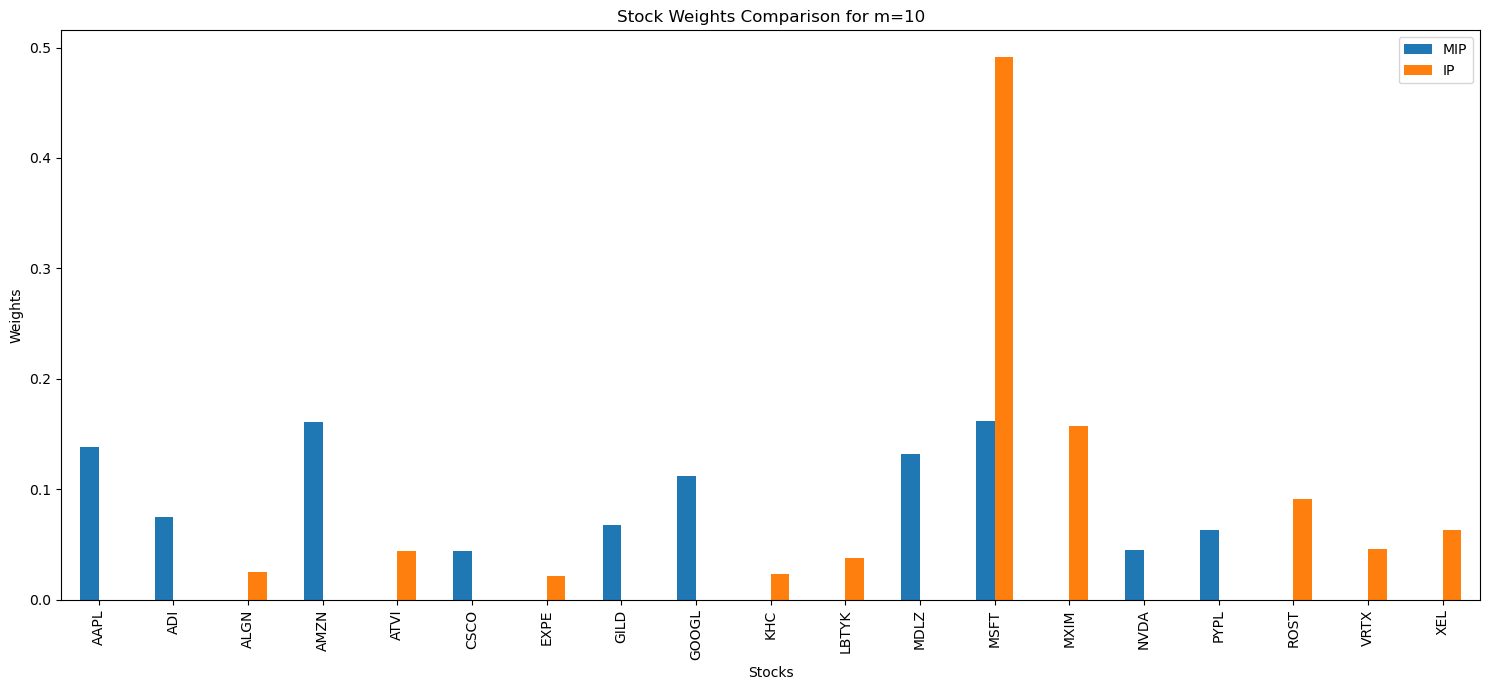

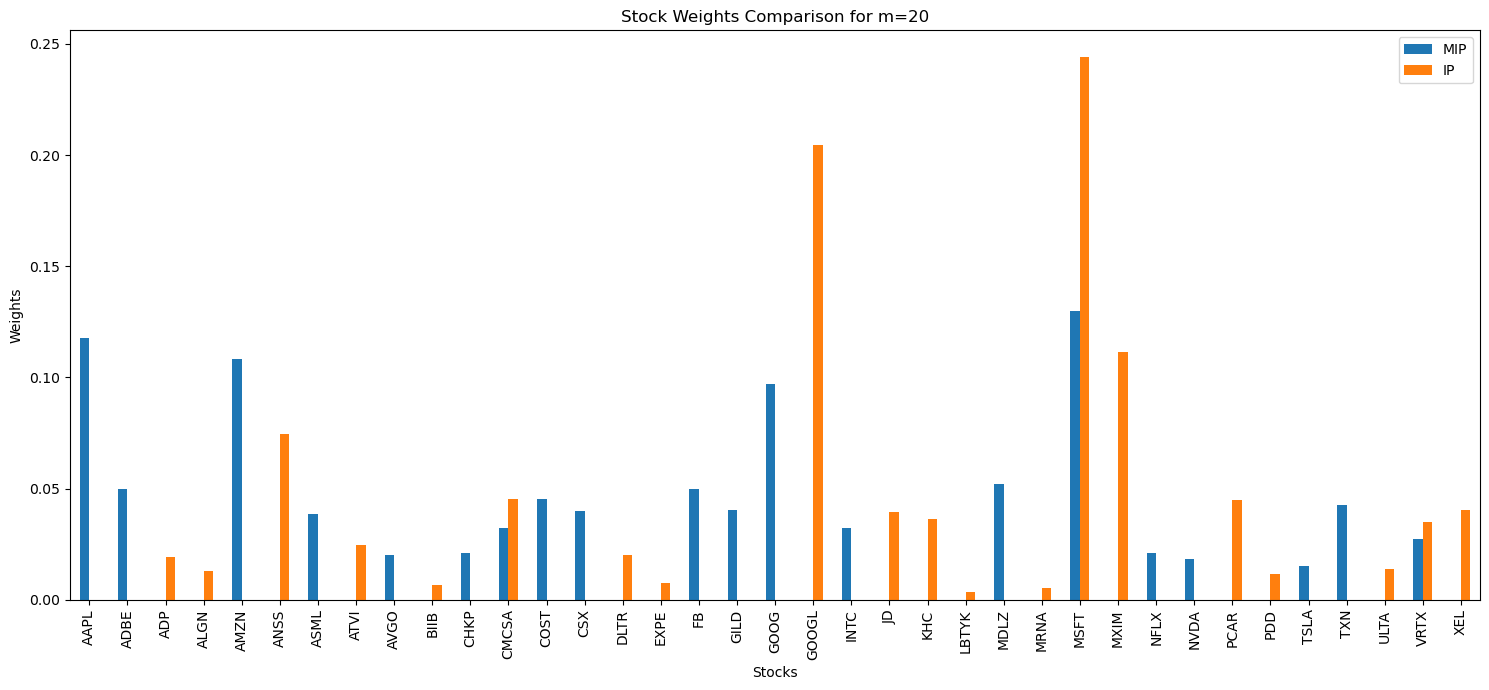

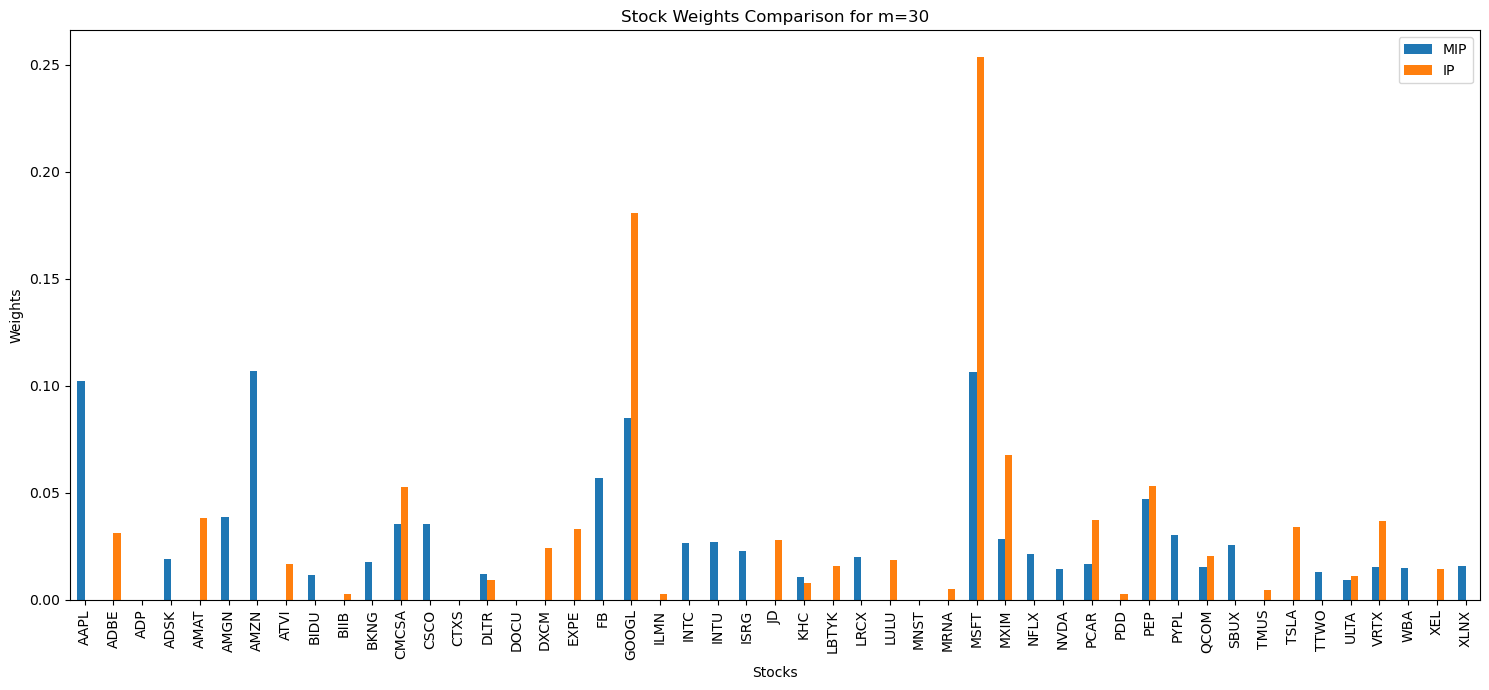

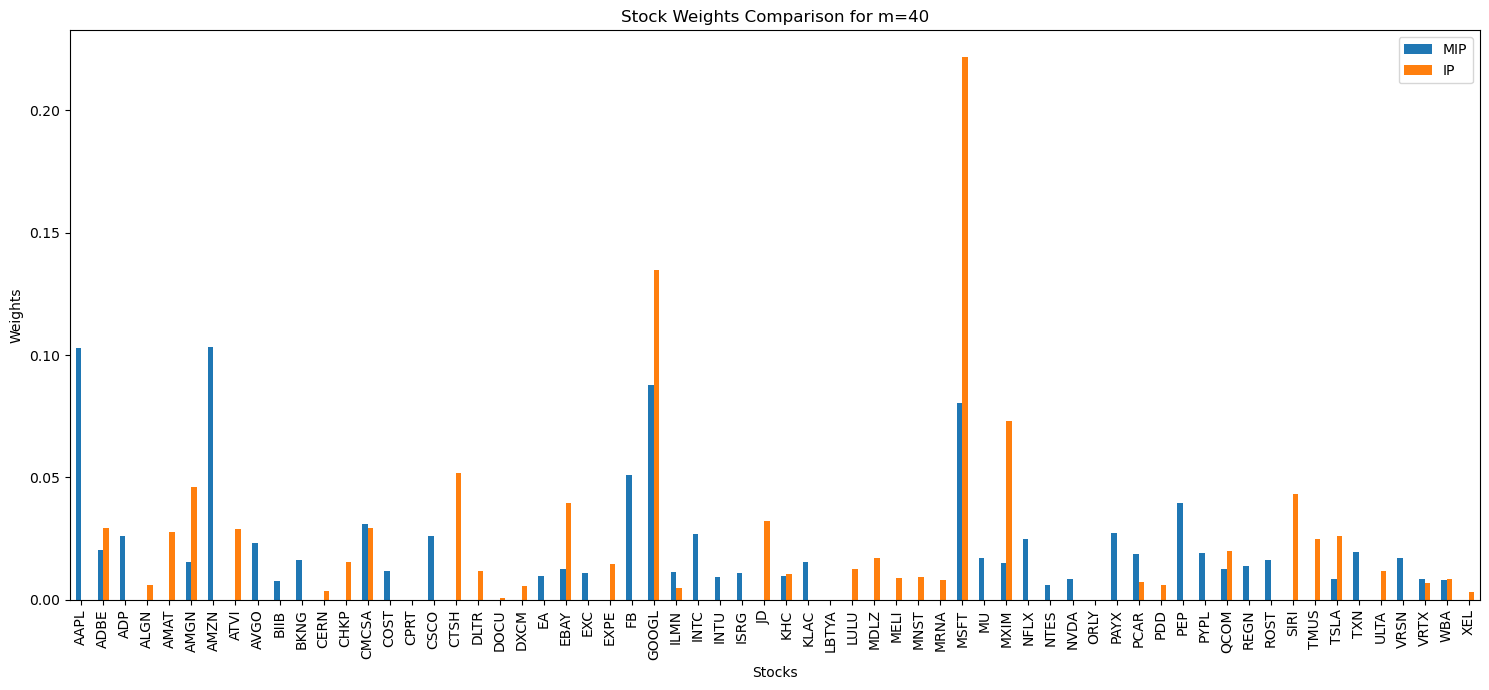

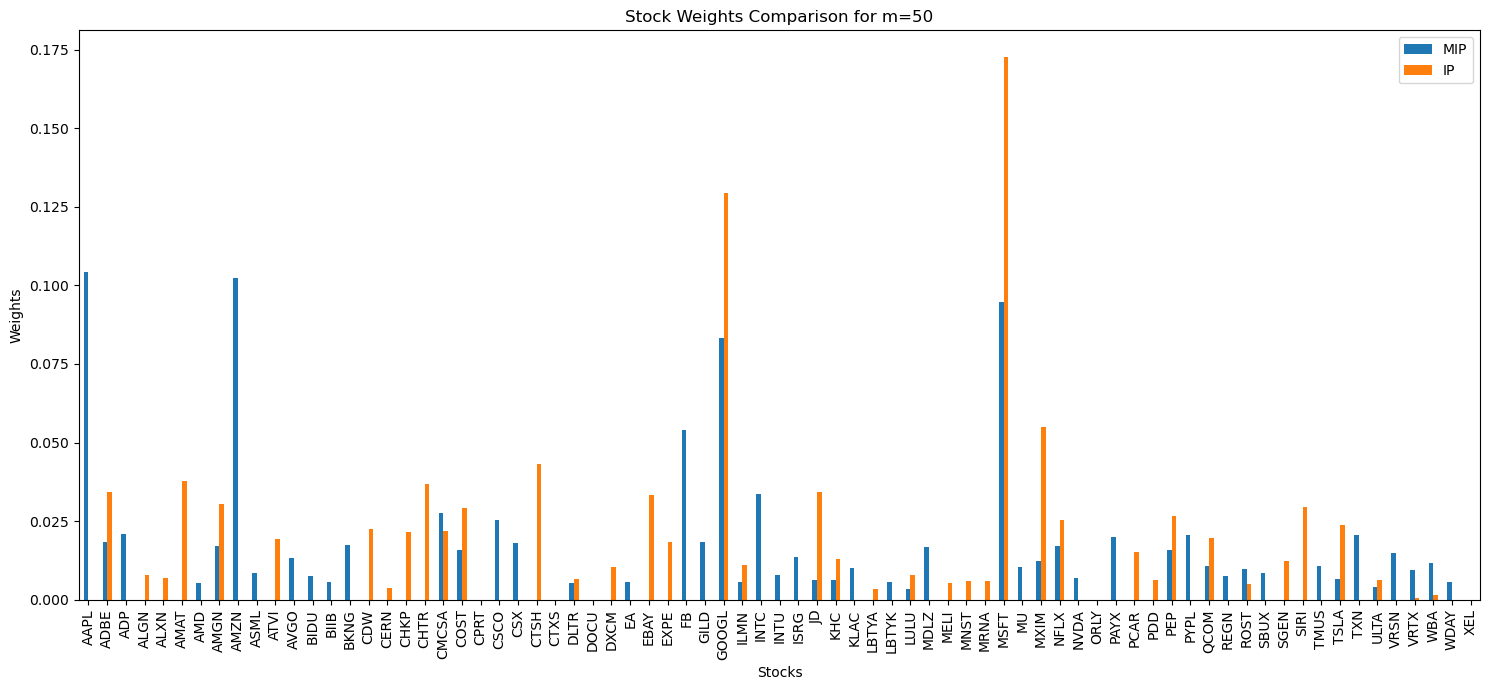

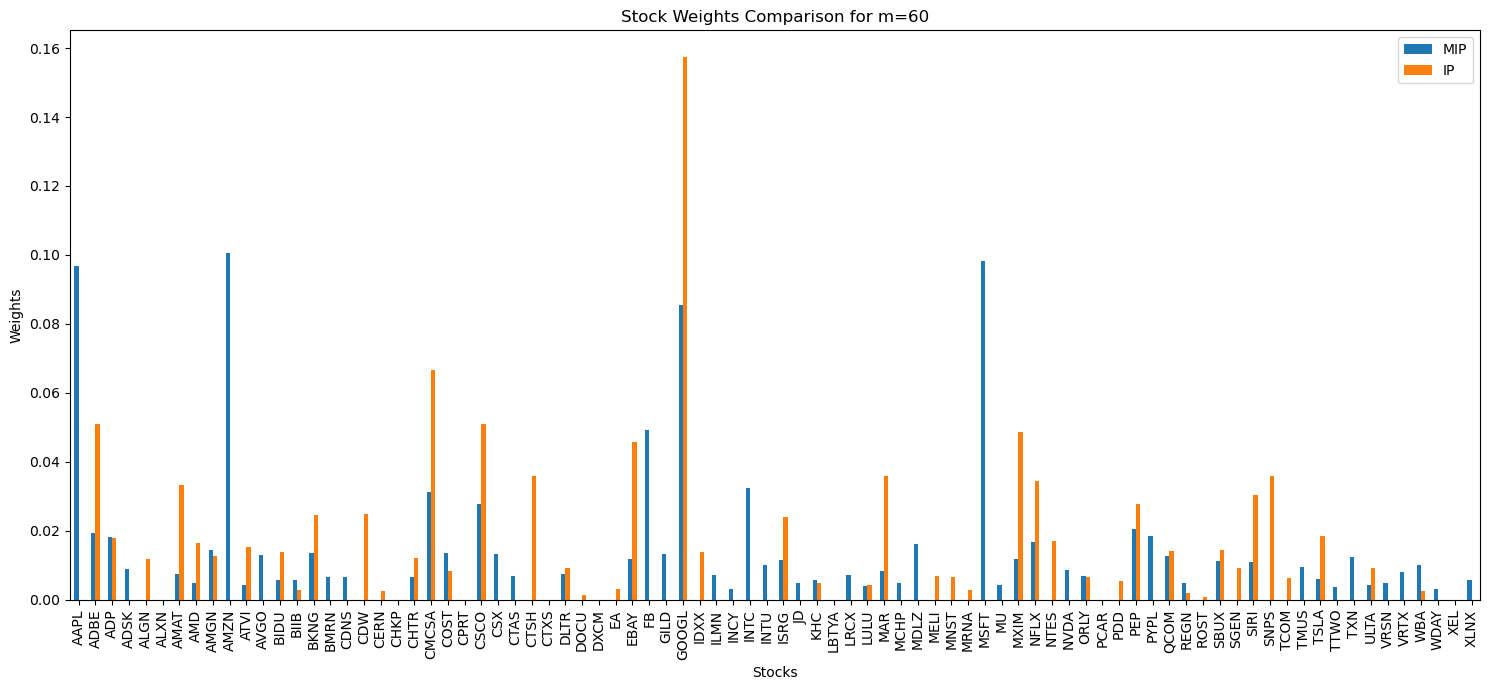

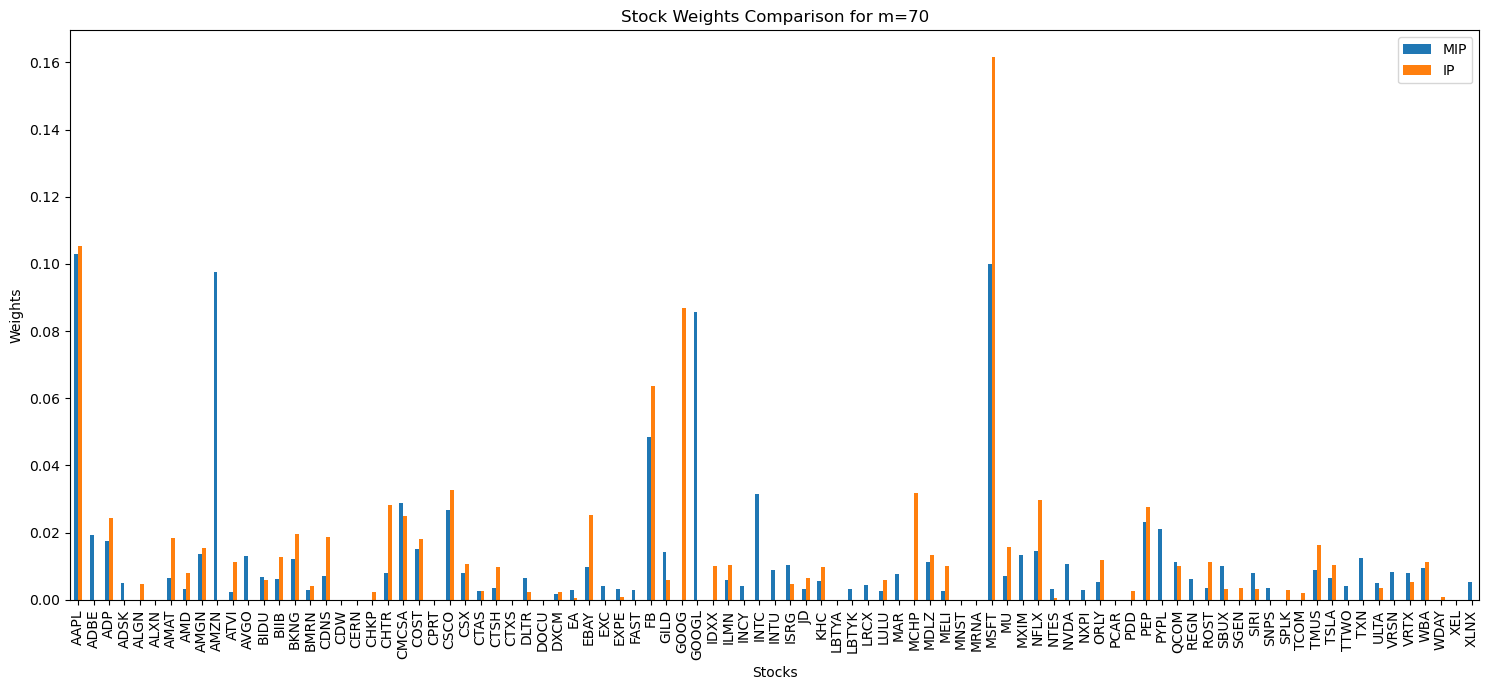

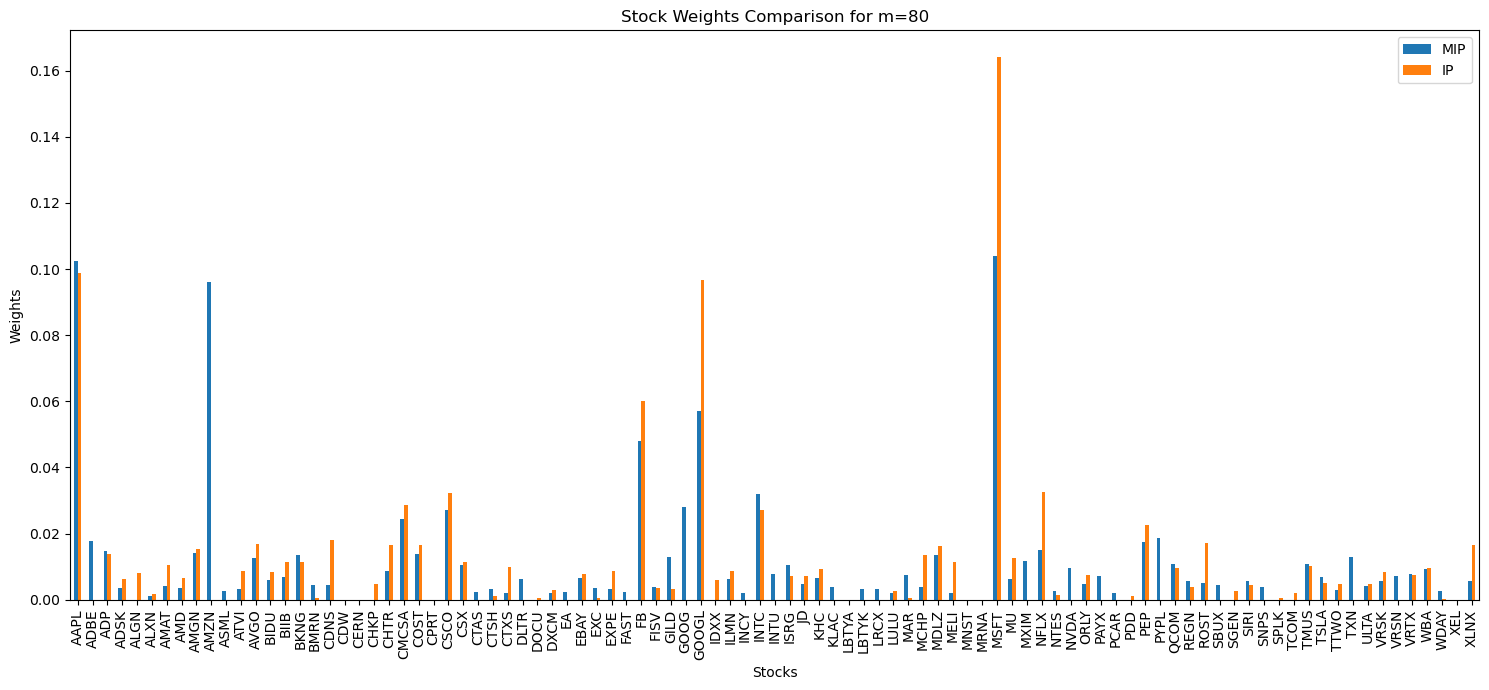

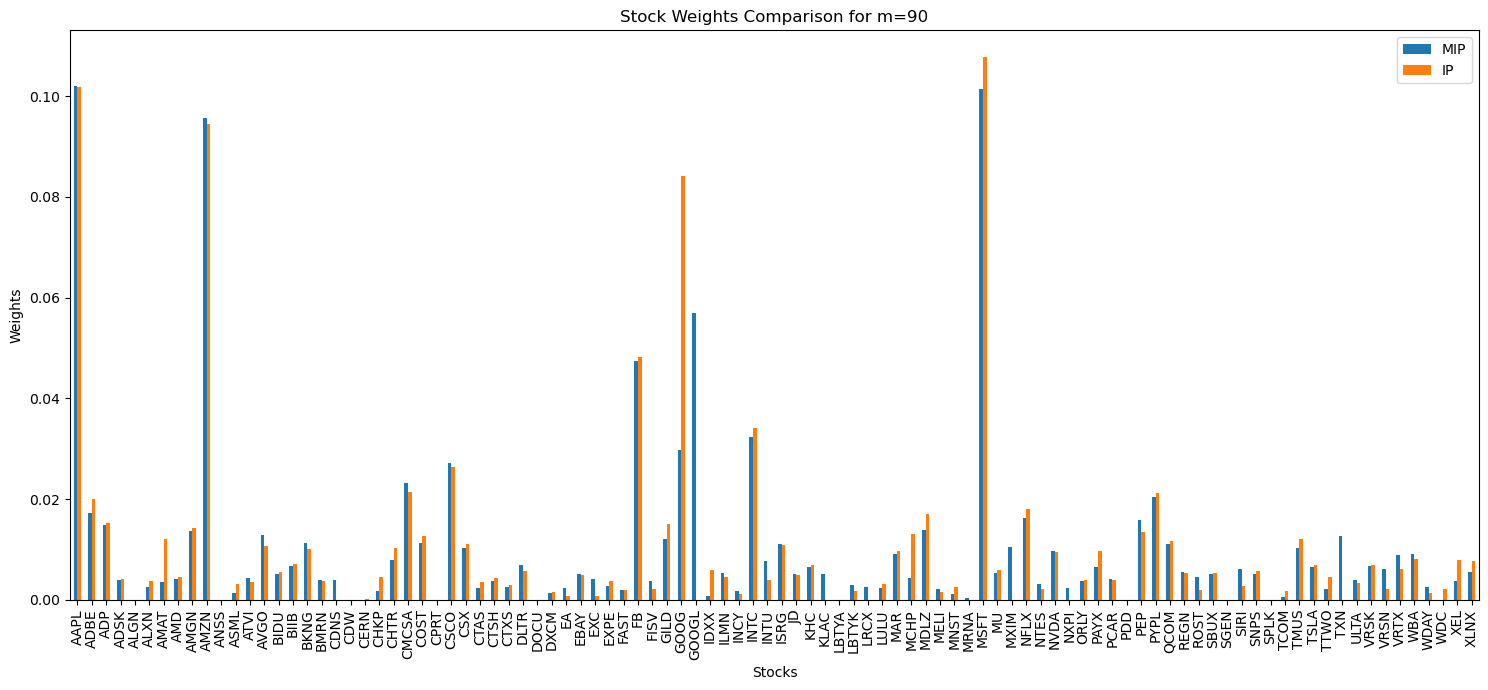

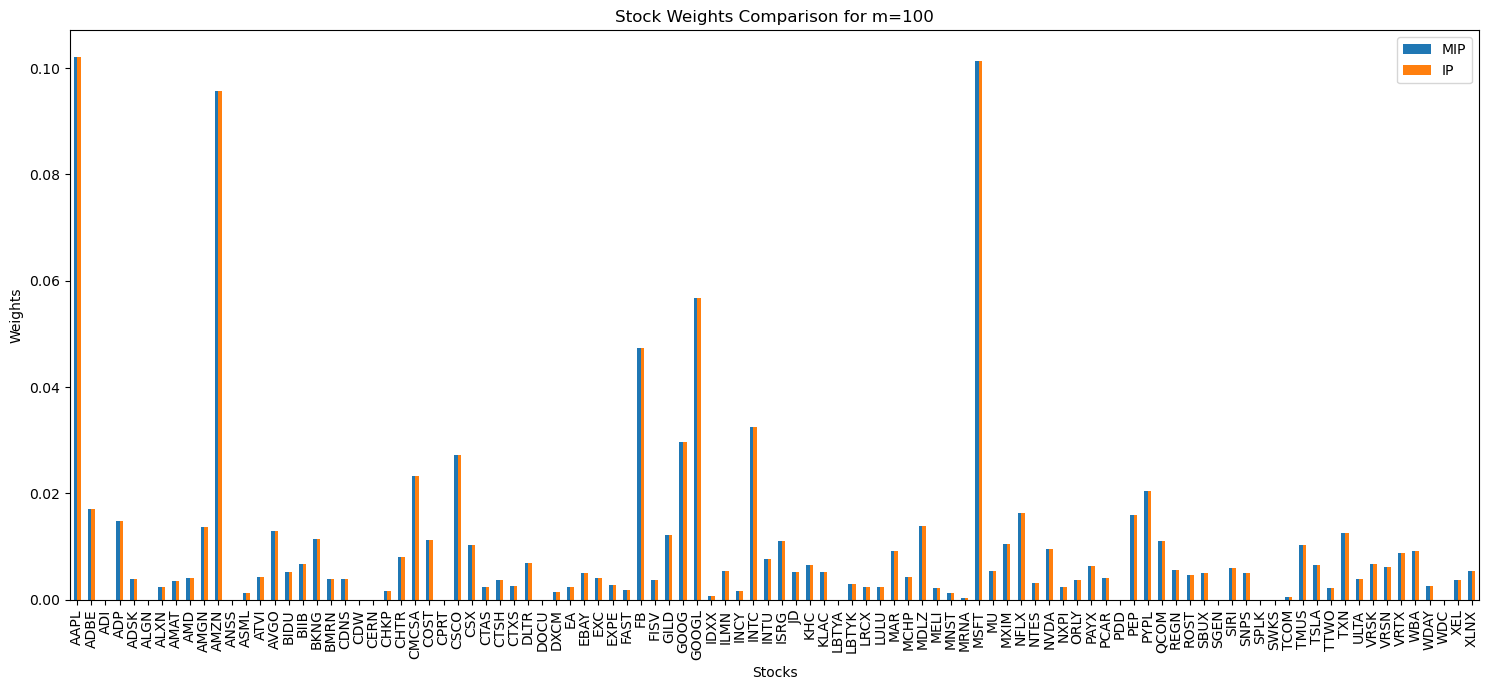

In [227]:



# Pivot the tables
pivoted_MIP = weights_MIP.pivot(index='m', columns='Stock', values='Weight')
pivoted_IP = weights_IP.pivot(index='m', columns='Stock', values='Weight')


for m_value in range(10,101,10):

    # Select the corresponding rows from each DataFrame
    weights_mip = pivoted_MIP.loc[m_value].dropna()  # dropna() to remove any NaN values due to stocks not present in this solution
    weights_ip = pivoted_IP.loc[m_value].dropna()

    # Create a new DataFrame for easier plotting
    comparison_df = pd.DataFrame({'MIP': weights_mip, 'IP': weights_ip})

    # Create the bar chart
    comparison_df.plot(kind='bar', figsize=(15,7))

    # Set the labels and title
    plt.xlabel('Stocks')
    plt.ylabel('Weights')
    plt.title(f'Stock Weights Comparison for m={m_value}')
    plt.xticks(rotation=90)
    plt.tight_layout()

    plt.show()



#### 2019 portfolio performance

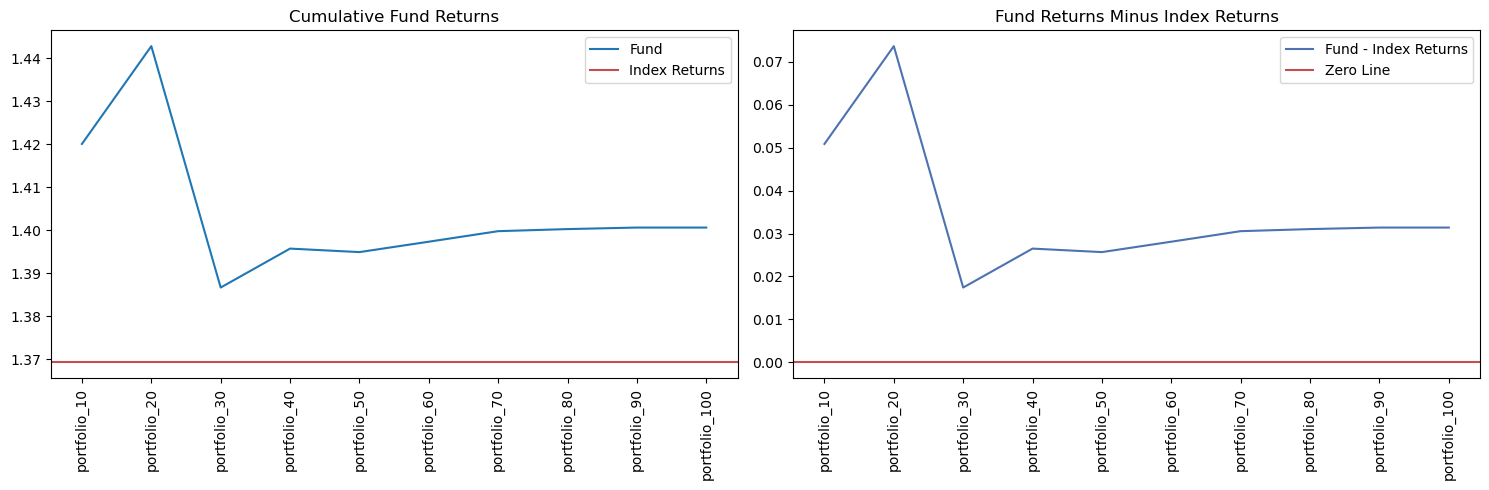

In [228]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (stacked vertically)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize to better fit both plots

# Calculate cumulative fund returns and index returns
cumulative_fund_returns = fund_returns_MIP.add(1).prod()
index_returns = index_returns_2019.add(1).prod()

# First subplot with cumulative fund returns
axes[0].plot(cumulative_fund_returns, label='Fund')
axes[0].axhline(y=index_returns, color='r', linestyle='-', label='Index Returns')
for label in axes[0].get_xticklabels():
    label.set_rotation(90)
axes[0].legend()  # Show the legend
axes[0].set_title('Cumulative Fund Returns')

# Second subplot with the difference from the index
returns_difference = cumulative_fund_returns - index_returns
axes[1].plot(returns_difference, label='Fund - Index Returns', color='b')
axes[1].axhline(y=0, color='r', linestyle='-', label='Zero Line')
for label in axes[1].get_xticklabels():
    label.set_rotation(90)
axes[1].legend()  # Show the legend
axes[1].set_title('Fund Returns Minus Index Returns')

plt.tight_layout()  # Ensure a neat layout
plt.show()  # Display the plots


#### 2020 Portfolio performance

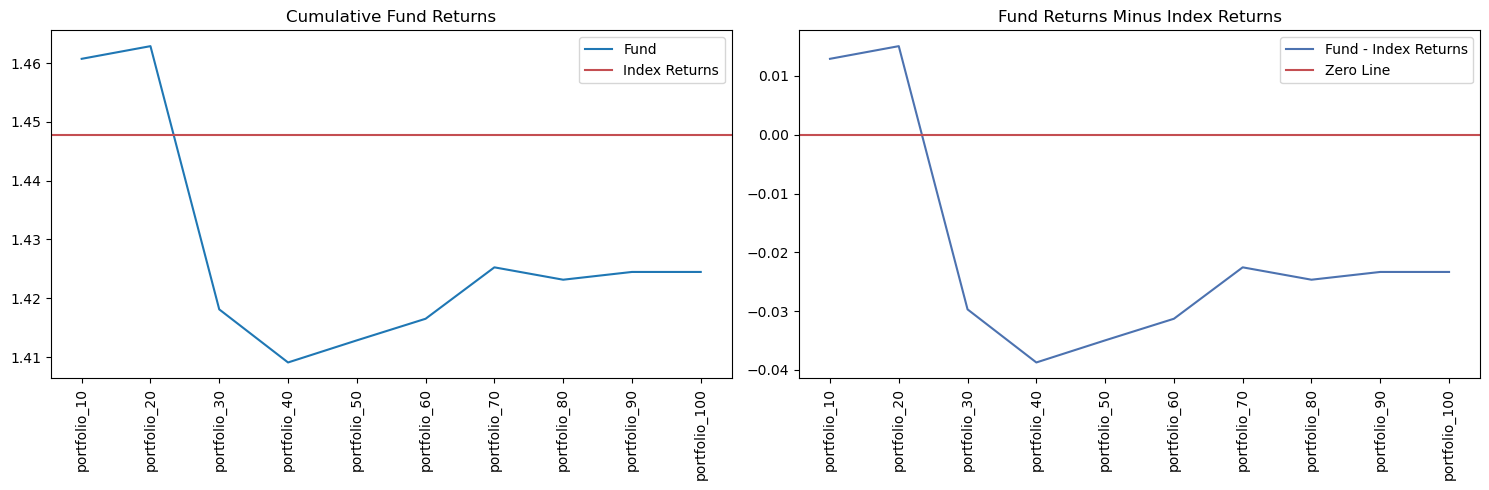

In [229]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (stacked vertically)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize to better fit both plots

# Calculate cumulative fund returns and index returns
cumulative_fund_returns = fund_returns_MIP_2020.add(1).prod()
index_returns = index_returns_2020.add(1).prod()

# First subplot with cumulative fund returns
axes[0].plot(cumulative_fund_returns, label='Fund')
axes[0].axhline(y=index_returns, color='r', linestyle='-', label='Index Returns')
for label in axes[0].get_xticklabels():
    label.set_rotation(90)
axes[0].legend()  # Show the legend
axes[0].set_title('Cumulative Fund Returns')

# Second subplot with the difference from the index
returns_difference = cumulative_fund_returns - index_returns
axes[1].plot(returns_difference, label='Fund - Index Returns', color='b')
axes[1].axhline(y=0, color='r', linestyle='-', label='Zero Line')
for label in axes[1].get_xticklabels():
    label.set_rotation(90)
axes[1].legend()  # Show the legend
axes[1].set_title('Fund Returns Minus Index Returns')

plt.tight_layout()  # Ensure a neat layout
plt.show()  # Display the plots


#### Plotting MIP funds

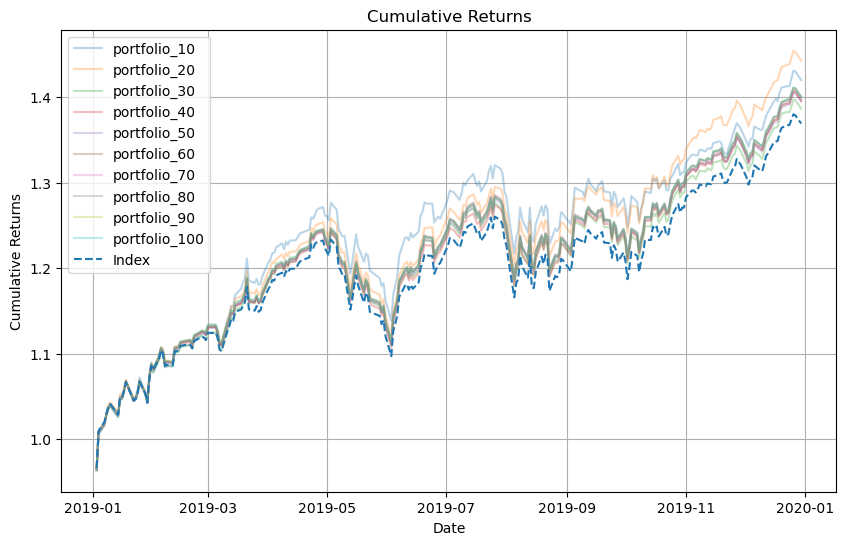

In [230]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(10, 6))

# Plot cumulative returns for all funds with 50% opacity
for column in fund_returns_MIP.columns:
    plt.plot(fund_returns_MIP.index, fund_returns_MIP[column].add(1).cumprod(), label=column, alpha=0.3)

# Plot cumulative returns for the index with full opacity and a different line style
plt.plot(index_returns_2019.index, index_returns_2019.add(1).cumprod(), label='Index', linestyle='--', alpha=1.0)

# Add a legend, title, and axis labels, and enable the grid
plt.legend(loc='upper left')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)

# Show the plot
plt.show()


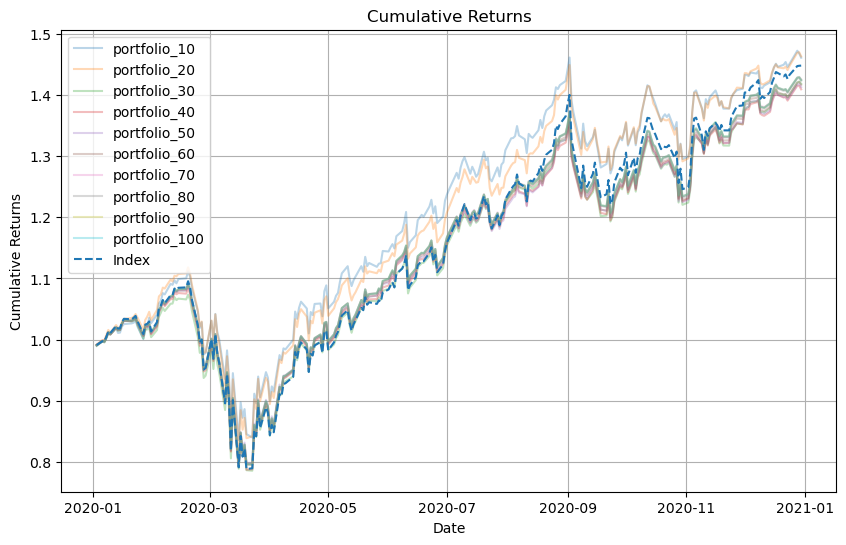

In [176]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(10, 6))

# Plot cumulative returns for all funds with 50% opacity
for column in fund_returns_MIP_2020.columns:
    plt.plot(fund_returns_MIP_2020.index, fund_returns_MIP_2020[column].add(1).cumprod(), label=column, alpha=0.3)

# Plot cumulative returns for the index with full opacity and a different line style
plt.plot(index_returns_2020.index, index_returns_2020.add(1).cumprod(), label='Index', linestyle='--', alpha=1.0)

# Add a legend, title, and axis labels, and enable the grid
plt.legend(loc='upper left')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)

# Show the plot
plt.show()


#### Tracking errors for MIP

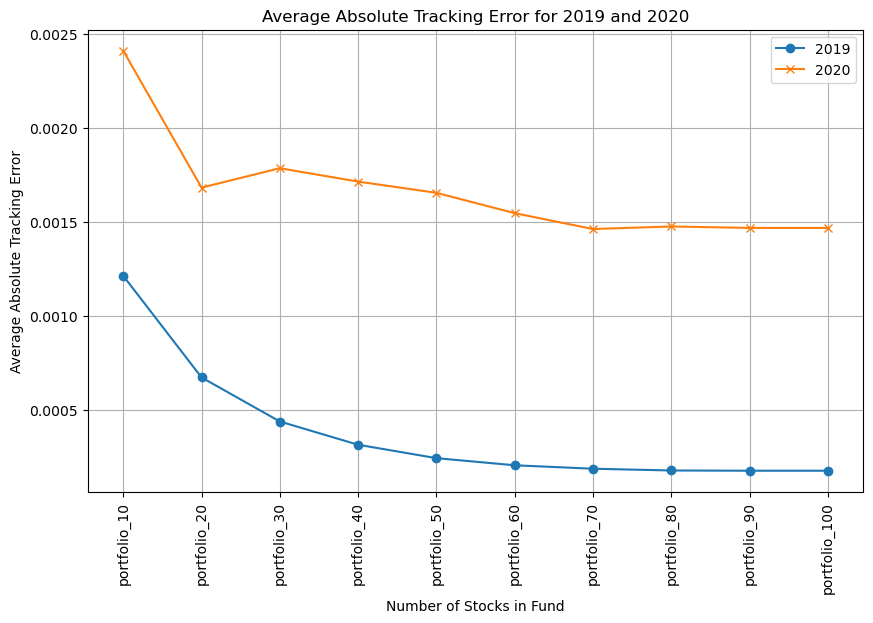

In [231]:

# Calculate tracking errors
tracking_error = fund_returns_MIP.subtract(index_returns_2019, axis=0)
tracking_error_2020 = fund_returns_MIP_2020.subtract(index_returns_2020, axis=0)

# Create a single figure and axes for both plots
plt.figure(figsize=(10, 6))

# Plot the average absolute tracking error for each year
plt.plot(tracking_error.columns, tracking_error.abs().mean(), marker='o', label='2019')
plt.plot(tracking_error_2020.columns, tracking_error_2020.abs().mean(), marker='x', label='2020')

# Customize the plot
plt.xticks(rotation=90)
plt.title('Average Absolute Tracking Error for 2019 and 2020')
plt.xlabel('Number of Stocks in Fund')
plt.ylabel('Average Absolute Tracking Error')
plt.grid(True)
plt.legend()  # Show the legend to distinguish between years

# Show the combined plot
plt.show()
